# Introduction

In this notebook, we will explore Modern Portfolio Theory (MPT) and construct the Efficient Frontier for a portfolio of three stocks: Amazon (AMZN), Coca-Cola (KO), and Microsoft (MSFT). The Efficient Frontier represents the set of optimal portfolios that offer the highest expected return for a given level of risk.

By the end of this notebook, you will:

- Fetch historical stock data using yfinance.
- Compute daily returns, annualized returns, and the covariance matrix.
- Simulate random portfolios to visualize the risk-return trade-off.
- Construct the Efficient Frontier.
- Identify the Global Minimum Variance (GMV) portfolio and the Maximum Sharpe Ratio (MSR) portfolio.

## Step 1: Import Libraries and Define Tickers

We start by importing the necessary libraries and defining the tickers for our portfolio.


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import edhec_risk_kit as erk  # Custom library for risk calculations

# Define the tickers and number of assets
tickers = ['AMZN', 'KO', 'MSFT']
n_assets = len(tickers)

## Step 2: Fetch Historical Data

We use yfinance to download historical stock prices for the selected tickers. The data is fetched from January 1, 2011, to January 1, 2019.


In [52]:
# Fetch historical stock data
stocks_data = yf.download(tickers, start='2011-01-01', end='2019-01-01')

# Display the first few rows of the closing prices
print("First 5 rows of the closing prices:")
print(stocks_data["Close"].head())

[*********************100%***********************]  3 of 3 completed

First 5 rows of the closing prices:
Ticker        AMZN         KO       MSFT
Date                                    
2011-01-03  9.2110  21.170368  21.460402
2011-01-04  9.2505  20.732143  21.544781
2011-01-05  9.3710  20.608803  21.475750
2011-01-06  9.2930  20.459488  22.104683
2011-01-07  9.2745  20.423777  21.935940


## Step 3: Compute Daily Returns

We calculate the daily returns for each stock using the closing prices. Daily returns are essential for computing annualized returns and the covariance matrix.

The daily return for a stock is calculated as:

$$ R_t = \frac{P_t - P_{t-1}}{P_{t-1}} $$

where:

- $R_t$ is the daily return at time $t$,
- $P_t$ is the closing price at time $t$,
- $P_{t-1}$ is the closing price at time $t-1$.


In [53]:
# Compute daily returns
daily_rets = erk.compute_returns(stocks_data["Close"])

# Display the first few rows of daily returns
print("\nFirst 5 rows of daily returns:")
print(daily_rets.head())


First 5 rows of daily returns:
Ticker          AMZN        KO      MSFT
Date                                    
2011-01-03       NaN       NaN       NaN
2011-01-04  0.004288 -0.020700  0.003932
2011-01-05  0.013026 -0.005949 -0.003204
2011-01-06 -0.008324 -0.007245  0.029286
2011-01-07 -0.001991 -0.001745 -0.007634


## Step 4: Compute Annualized Returns and Covariance Matrix

We annualize the daily returns and compute the covariance matrix of daily returns. These metrics are crucial for portfolio optimization.

### Annualized Returns

The annualized return is calculated as:

$$ \text{Annualized Return} = \left( \prod_{t=1}^{T} (1 + R_t) \right)^{\frac{n}{T}} - 1 $$

where:

- $R_t$ is the daily return at time $t$,
- $T$ is the total number of periods,
- $n$ is the number of periods in a year (252 for trading days).

### Covariance Matrix

The covariance matrix $\Sigma$ is computed as:

$$ \Sigma_{ij} = \text{Cov}(R_i, R_j) $$

where $R_i$ and $R_j$ are the returns of assets $i$ and $j$, respectively.


In [54]:
# Annualize returns (252 trading days in a year)
ann_rets = erk.annualize_rets(daily_rets, 252)

# Compute the mean daily returns and the covariance of daily returns
mean_rets = daily_rets.mean()
std_rets = daily_rets.std()
cov_rets = daily_rets.cov()

print("\nAnnualized Returns:")
print(ann_rets)

print("\nCovariance Matrix:")
print(cov_rets)


Annualized Returns:
Ticker
AMZN    0.300595
KO      0.080584
MSFT    0.205678
dtype: float64

Covariance Matrix:
Ticker      AMZN        KO      MSFT
Ticker                              
AMZN    0.000397  0.000047  0.000137
KO      0.000047  0.000082  0.000049
MSFT    0.000137  0.000049  0.000213


## Step 5: Simulate Random Portfolios

We simulate thousands of random portfolios by assigning random weights to the assets. For each portfolio, we compute the annualized return, volatility, and Sharpe ratio.

### Portfolio Return

The portfolio return $R_p$ is calculated as:

$$ R_p = \sum_{i=1}^{N} w_i \cdot R_i $$

where:

- $w_i$ is the weight of asset $i$,
- $R_i$ is the return of asset $i$,
- $N$ is the total number of assets.

### Portfolio Volatility

The portfolio volatility $\sigma_p$ is calculated as:

$$ \sigma_p = w^T \Sigma w $$

where:

- $w$ is the vector of asset weights,
- $\Sigma$ is the covariance matrix of asset returns,
- $w^T$ is the transpose of the weight vector.

### Sharpe Ratio

The Sharpe ratio $S$ is calculated as:

$$ S = \frac{R_p - R_f}{\sigma_p} $$

where:

- $R_p$ is the portfolio return,
- $R_f$ is the risk-free rate,
- $\sigma_p$ is the portfolio volatility.


In [55]:
# Define parameters
periods_per_year = 252
num_portfolios = 4000
risk_free_rate = 0.03

# Initialize a DataFrame to store portfolio results
portfolios = pd.DataFrame(columns=["return", "volatility", "sharpe ratio", "w1", "w2", "w3"])

# Simulate random portfolios
for i in range(num_portfolios):
    # Select random weights
    weights = np.random.random(n_assets)
    # Rescale them to sum to 1
    weights /= np.sum(weights)

    # Annualized portfolio returns
    portfolio_ret = np.dot(weights, ann_rets)

    # Annualized portfolio volatility
    portfolio_vol = erk.portfolio_volatility(weights, cov_rets)
    portfolio_vol = erk.annualize_vol(portfolio_vol, periods_per_year)

    # Annualized portfolio Sharpe ratio
    portfolio_spr = erk.sharpe_ratio(portfolio_ret, risk_free_rate, periods_per_year, v=portfolio_vol)

    # Create a new DataFrame row
    portfolio_row = pd.DataFrame({"return": [portfolio_ret],
                                  "volatility": [portfolio_vol],
                                  "sharpe ratio": [portfolio_spr],
                                  "w1": [weights[0]], "w2": [weights[1]], "w3": [weights[2]]})

    # Use pd.concat() to append the row to the portfolios DataFrame
    portfolios = pd.concat([portfolios, portfolio_row], ignore_index=True)

# Display the first few rows of the portfolios DataFrame
print("\nFirst 5 rows of simulated portfolios:")
print(portfolios.head())


First 5 rows of simulated portfolios:
     return  volatility  sharpe ratio        w1        w2        w3
0  0.153983    0.151353      0.819164  0.222463  0.582043  0.195494
1  0.198394    0.184310      0.913646  0.403079  0.364065  0.232856
2  0.223039    0.205174      0.940854  0.425177  0.183829  0.390993
3  0.150748    0.153280      0.787756  0.089207  0.506799  0.403994
4  0.212899    0.199206      0.918142  0.481753  0.307812  0.210435


## Step 6: Identify Key Portfolios

From the simulated portfolios, we identify two key portfolios:

- **Global Minimum Variance (GMV) Portfolio**: The portfolio with the lowest volatility.
- **Maximum Sharpe Ratio (MSR) Portfolio**: The portfolio with the highest Sharpe ratio.


In [56]:
# Find the GMV portfolio
low_vol_portfolio = portfolios.iloc[portfolios['volatility'].idxmin()]

# Find the MSR portfolio
high_sharpe_portfolio = portfolios.iloc[portfolios['sharpe ratio'].idxmax()]

print("\nGlobal Minimum Variance (GMV) Portfolio:")
print(low_vol_portfolio)

print("\nMaximum Sharpe Ratio (MSR) Portfolio:")
print(high_sharpe_portfolio)


Global Minimum Variance (GMV) Portfolio:
return          0.108800
volatility      0.138354
sharpe ratio    0.569553
w1              0.047498
w2              0.810478
w3              0.142024
Name: 2337, dtype: float64

Maximum Sharpe Ratio (MSR) Portfolio:
return          0.248167
volatility      0.230672
sharpe ratio    0.945789
w1              0.490033
w2              0.032166
w3              0.477801
Name: 3579, dtype: float64


## Step 7: Plot the Efficient Frontier

We visualize the simulated portfolios and the Efficient Frontier. The GMV and MSR portfolios are highlighted on the plot.


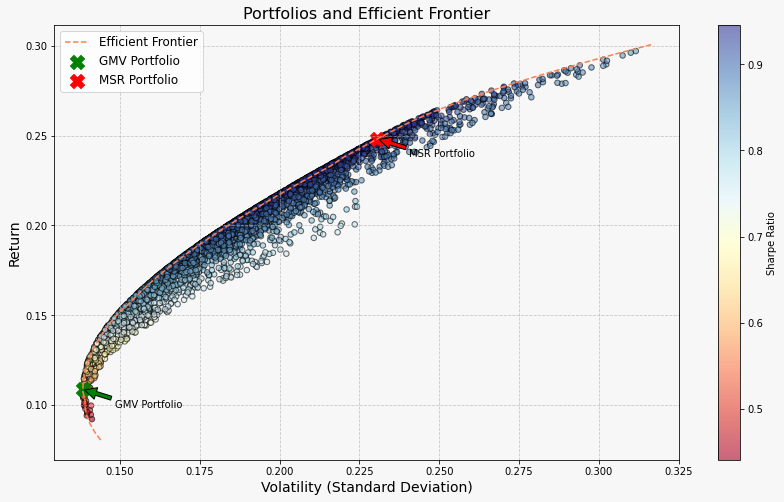

In [58]:
# Plot the Efficient Frontier
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Scatter plot of simulated portfolios
im = ax.scatter(portfolios["volatility"], portfolios["return"], c=portfolios["sharpe ratio"], s=30, edgecolor='k', cmap='RdYlBu', alpha=0.6)
ax.set_title("Portfolios and Efficient Frontier", fontsize=16)
ax.set_xlabel("Volatility (Standard Deviation)", fontsize=14)
ax.set_ylabel("Return", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_facecolor('#f7f7f7')
fig.patch.set_facecolor('#f7f7f7')

# Plot the Efficient Frontier line
df = erk.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
ax.plot(df["volatility"], df["return"], linestyle="--", color="coral", label="Efficient Frontier")

# Highlight GMV and MSR portfolios
ax.scatter(low_vol_portfolio["volatility"], low_vol_portfolio["return"], marker="X", color='g', s=200, label="GMV Portfolio")
ax.scatter(high_sharpe_portfolio["volatility"], high_sharpe_portfolio["return"], marker="X", color='r', s=200, label="MSR Portfolio")

# Annotate GMV and MSR points
ax.annotate('GMV Portfolio', xy=(low_vol_portfolio["volatility"], low_vol_portfolio["return"]),
            xytext=(low_vol_portfolio["volatility"] + 0.01, low_vol_portfolio["return"] - 0.01),
            arrowprops=dict(facecolor='green', shrink=0.05))

ax.annotate('MSR Portfolio', xy=(high_sharpe_portfolio["volatility"], high_sharpe_portfolio["return"]),
            xytext=(high_sharpe_portfolio["volatility"] + 0.01, high_sharpe_portfolio["return"] - 0.01),
            arrowprops=dict(facecolor='red', shrink=0.05))

#ax.set_xlim([0.125, 0.33])
ax.legend(fontsize=12)

# Add colorbar for Sharpe ratio
fig.colorbar(im, ax=ax, label="Sharpe Ratio")
plt.show()

## Step 8: Conclusion

In this notebook, we:

- Fetched historical stock data for AMZN, KO, and MSFT.
- Computed daily returns, annualized returns, and the covariance matrix.
- Simulated thousands of random portfolios to explore the risk-return trade-off.
- Constructed the Efficient Frontier and identified the GMV and MSR portfolios.

The Efficient Frontier plot provides a visual representation of the optimal portfolios. The GMV Portfolio represents the portfolio with the lowest risk, while the MSR Portfolio offers the highest return per unit of risk. These portfolios are essential for investors seeking to optimize their portfolios based on their risk tolerance.
